In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM\ project/LSTM/sector_analysis(food drug)

/content
/content/drive/MyDrive/LSTM project/LSTM/sector_analysis(food drug)


# Make models

In [7]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    # ss=StandardScaler()
    # ss_others=ss.fit_transform(training_set_others)
    # ss_v=ss.fit_transform(training_set_volume)
    # concat=np.hstack((ss_others, ss_v))
    # print(concat.shape)
    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("Volume含む")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("Volume含まない")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    if V:
      print("Here check")
      print(f"output=1, inputs={v}, outputs={output_c}")
      training_set_others=np.hstack((data[:,:-1] for data in train_data))
      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))

      # ss1=StandardScaler()
      # ss_others=ss1.fit_transform(training_set_others)

      # ss_v=ss1.fit_transform(training_set_volume)
      # concat=np.hstack((ss_others, ss_v))
      # print(f"concat={concat.shape}")

      ss_others=[]
      for i in range(training_set_others.shape[1]):
        ss1=StandardScaler()
        ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
      ss_others=np.hstack(ss_others)

      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)
      concat=np.hstack((ss_others, ss_v))
      print(f"concat={concat.shape}")

      if len(c)>=2:
        ind=[i for i in range(v.index(output_i[0]), len(c)*(len(v)-1), len(v)-1)]
      else:
        ind=[v.index(output_i[0])]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

    else: # volume含まれていない時
      print("error!")
      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()
      ss_others=ss2.fit_transform(training_set_all)
      concat=ss_others
      ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  print("Check")
  model_lists = []
  for l in range(len(y_trains2)):
    print(f"{l+1}/{len(y_trains2)}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 30, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 10))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  print("finish making models")
  return model_lists, y_trains2

# Make preds

In [28]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  print(f"inputs = {np.array(inputs).shape}")

  #train_data=(11, 754, 2), test_data=(11, 252, 2)
  # inputs = (11, 282, 2)
  # Volumeを含むケース
  # inputs = (11, 282, 2)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  print(f"inputs2={inputs2.shape}")
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")
  #X_test=(252, 30, 22)

  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]
    print(ind)

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual lists={np.array(actual_lists).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(r)
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    # plt.title(f"{}")
    plt.xlabel('Time series')
    plt.ylabel('Stock Price (or Volume)')
    
    # use correlation
    print(f"R2{R2[p]}={r2_score(actual_lists[p], preds[p].flatten())}")
 
    R +=r2_score(actual_lists[p], preds[p].flatten())
    plt.legend()
    plt.show()

    if p in r:
      print(f"R2-{len(c)}companies_average={R/len(c)}")
      R=0
      print("")

  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  for p in range(len(output_i)):
    print(f"Preds_Heatmap={output_c[p]} correlation")
    prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
    # print(len(prd))
    Preds= pd.DataFrame(np.concatenate(prd, axis=1))
    Preds.columns = columns
    # print(Preds.columns)
    plt.figure(figsize=(8, 6))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# "Experiments"
###Sector: Food & Drug

### Criteria: Profits/Employees 

In [6]:
# sector-> Food & Drug store(2017/01/01~2020/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


In [25]:
c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]
# c=[df1, df2]
# nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
# Basically, we can remove "Date" and "Adj Close"
input=[2, 6] #item' index chosen as imputs
output_c=['High', 'Volume'] # item values of output
output_i=[2, 6] # item number of output

train_size=754
time_step=30
epochs=20
units=50 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [26]:
o1, o2 = make_models(c, nl, input, V=V, output_c=output_c, output_i=output_i, train_size=train_size, 
                     time_step=time_step, epochs=epochs, units=units)

train_data=(11, 754, 2), test_data=(11, 252, 2)
output>=2, inputs=[2, 6], outputs=['High', 'Volume']
concat=(754, 22)
Volume含む
len(ind)=22, ind=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
724 15928
X_train=(724, 30, 22), y_trains=(15928,)
y_trains2=(22, 724)
Check
1/22
Epoch 1/20
23/23 [==============================] - 7s 47ms/step - loss: 0.8114
Epoch 2/20
23/23 [==============================] - 1s 48ms/step - loss: 0.3106
Epoch 3/20
23/23 [==============================] - 1s 47ms/step - loss: 0.2066
Epoch 4/20
23/23 [==============================] - 1s 48ms/step - loss: 0.1452
Epoch 5/20
23/23 [==============================] - 1s 47ms/step - loss: 0.1009
Epoch 6/20
23/23 [==============================] - 1s 49ms/step - loss: 0.1045
Epoch 7/20
23/23 [==============================] - 1s 47ms/step - loss: 0.0828
Epoch 8/20
23/23 [==============================] - 1s 48ms/step - loss: 0.0779
Epoch 9/20
23/23 [==============================] - 1s 

train_data=(11, 754, 2), test_data=(11, 252, 2)
inputs = (11, 282, 2)
inputs2=(282, 22)
X_test=(252, 30, 22)
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
finish making predictions
actual lists=(22, 252), preds_list=(22, 252, 1)
[10, 21]
R2Seven & I Holdings (Japan)=-0.530593025706561


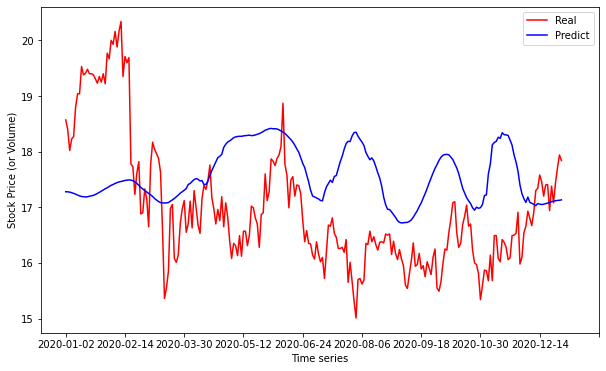

R2Walgreens Boots Alliance (USA)=-0.2545840438784439


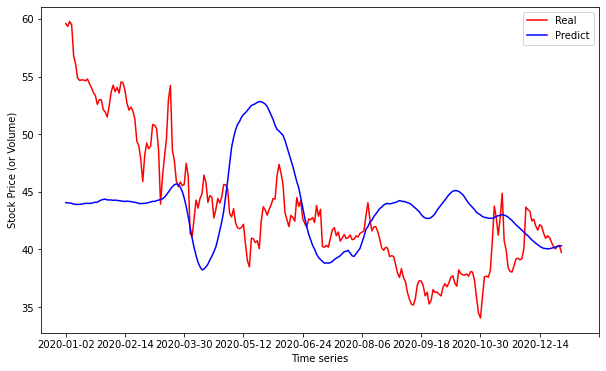

R2Metro (Canada)=-0.8976997664665014


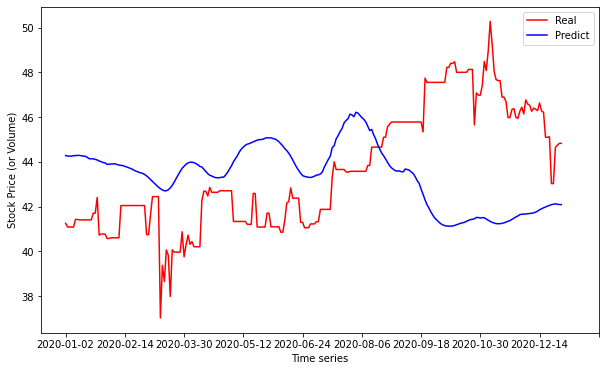

R2Coop Group (Switzerland)=0.46433467512425464


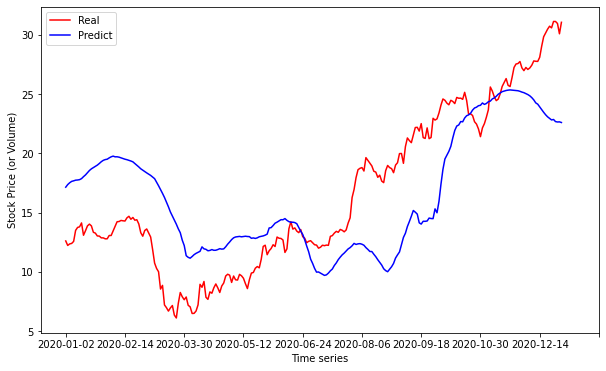

R2J.Sainsbury(Britain)=0.2335332790438962


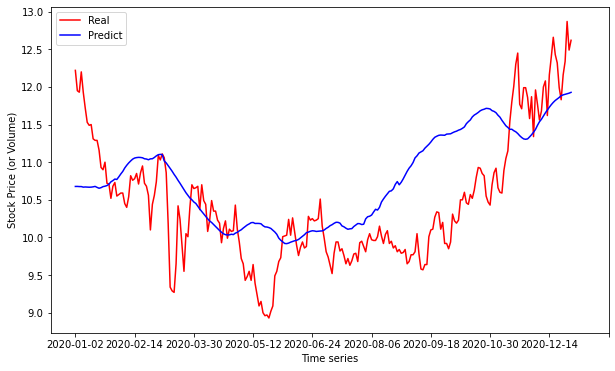

R2Royal Ahold Delhaize(Netherlands)=-1.045472255688733


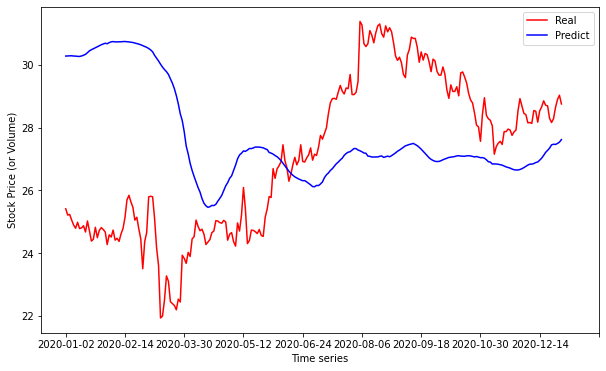

R2Tesco(Britain)=0.45400308984376536


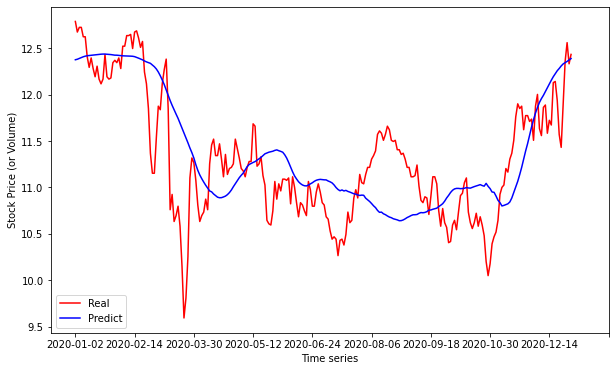

R2Kroger(USA)=0.01399022296039143


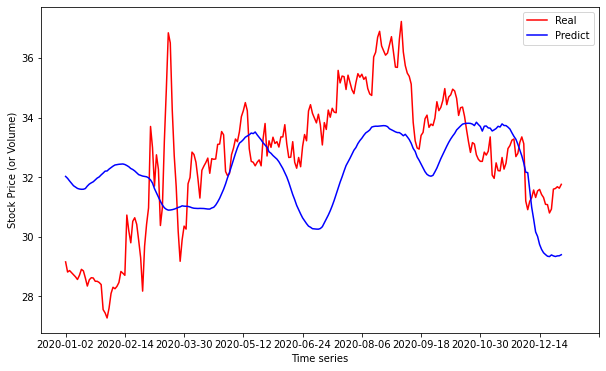

R2AEON(Japan)=-0.16934514594441863


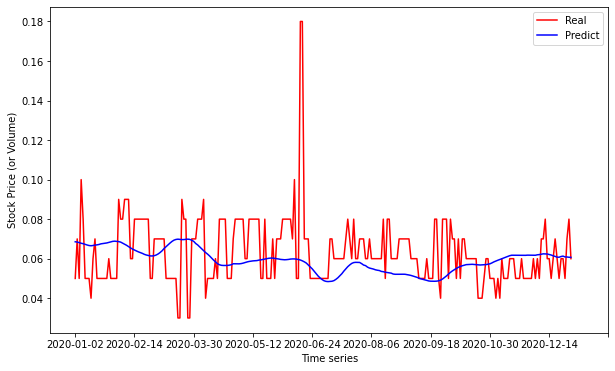

R2Carrefour(France)=-0.6408878305329098


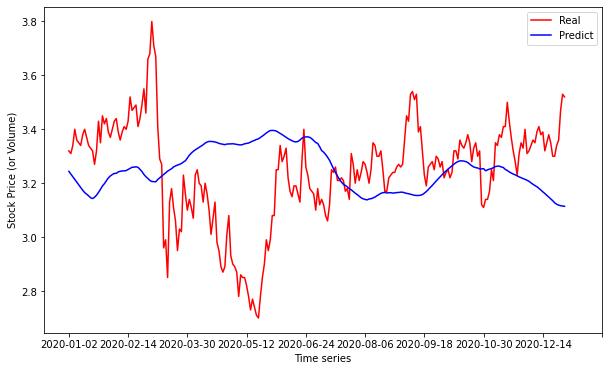

R2George Weston(Canada)=0.17215814253350203


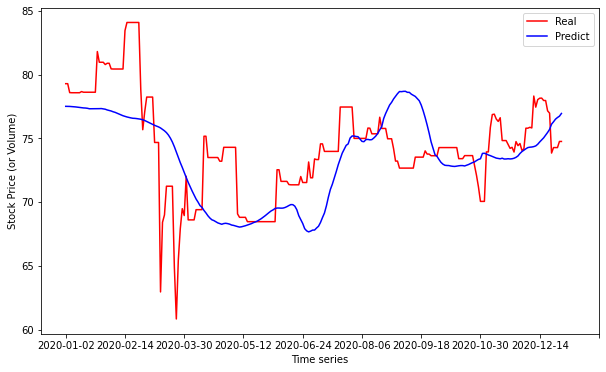

R2-11companies_average=-0.20005115079197805

R2Seven & I Holdings (Japan)=-0.2854751284833621


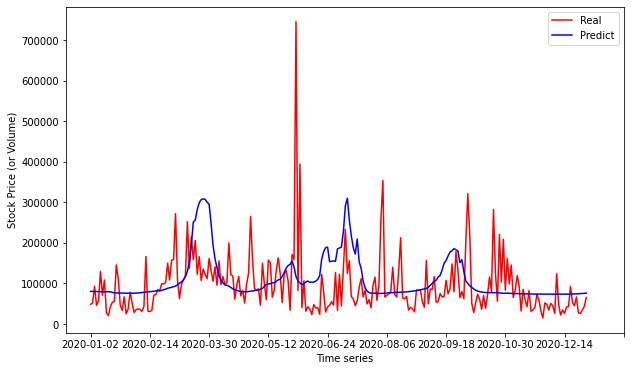

R2Walgreens Boots Alliance (USA)=-0.16714178001616165


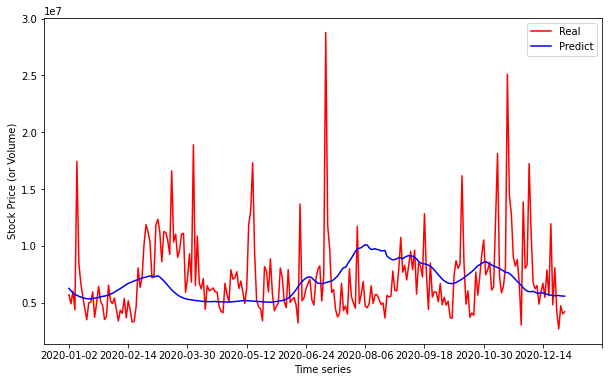

R2Metro (Canada)=-0.06420801489285033


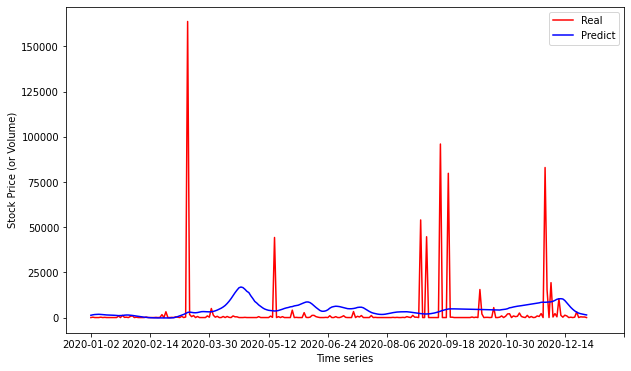

R2Coop Group (Switzerland)=-0.20747205070280272


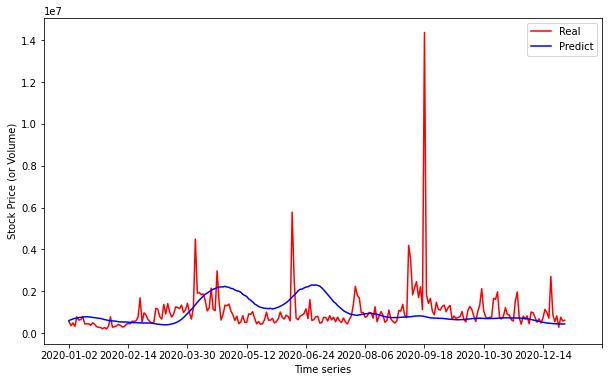

R2J.Sainsbury(Britain)=-0.2494143050121882


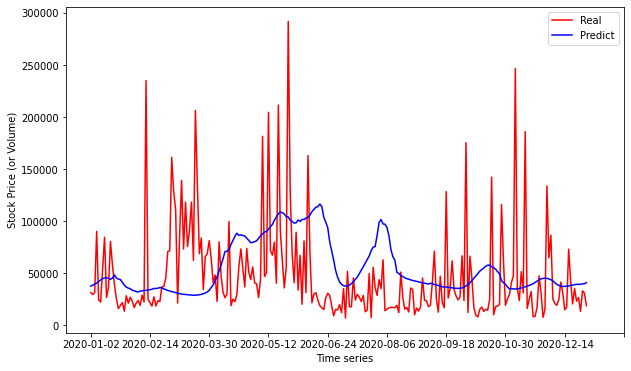

R2Royal Ahold Delhaize(Netherlands)=-0.8425378371335894


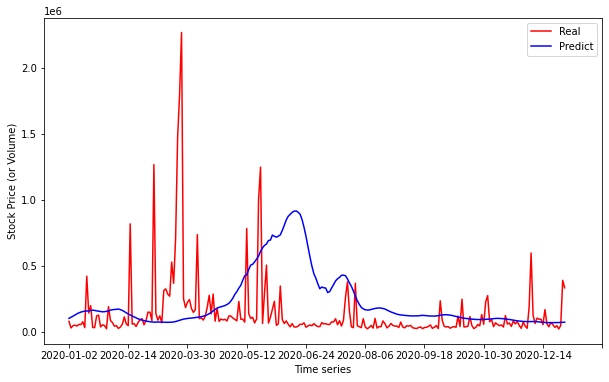

R2Tesco(Britain)=-1.0404285159375717


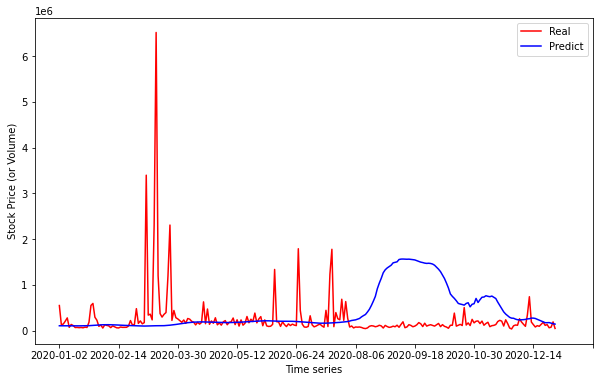

R2Kroger(USA)=-0.27931499605528587


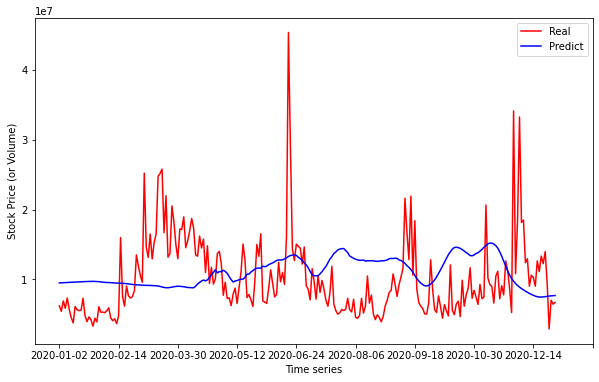

R2AEON(Japan)=-0.7904790264918056


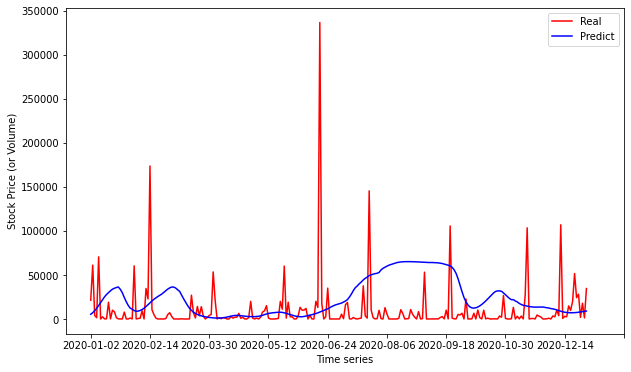

R2Carrefour(France)=0.02795527105730633


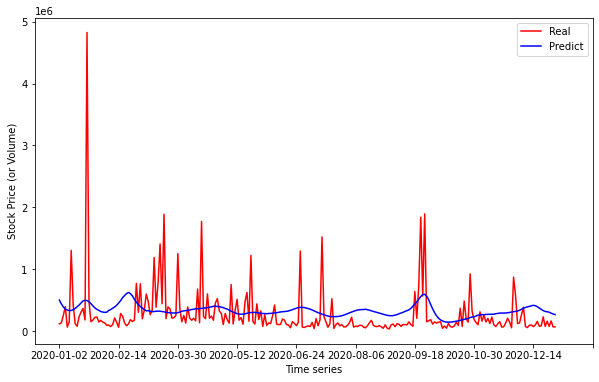

R2George Weston(Canada)=-0.05276759650359342


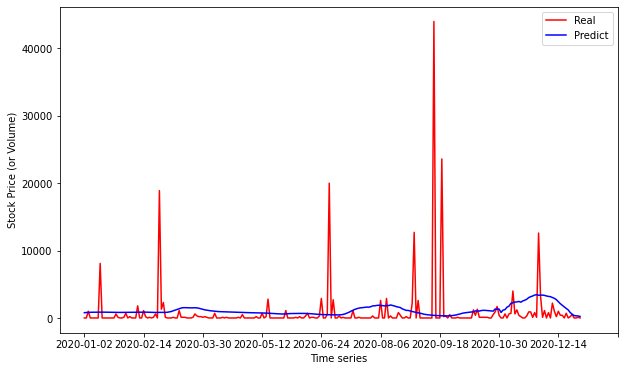

R2-11companies_average=-0.3592076345610822

Preds_Heatmap=High correlation
Preds_Heatmap=Volume correlation


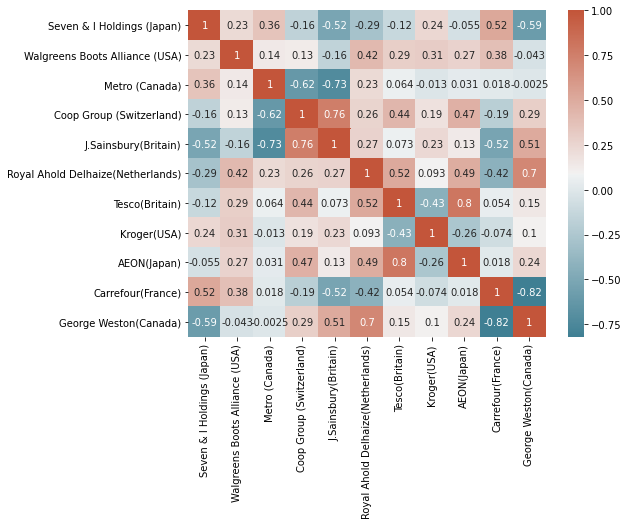

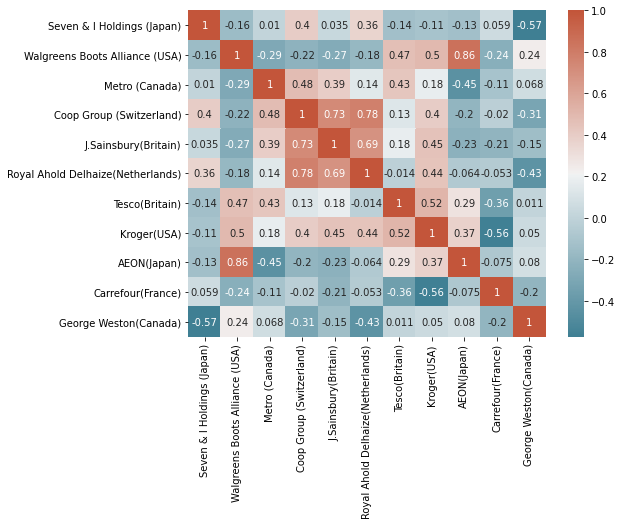

In [29]:
t1 = make_preds(c, nl, v, o1, o2, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [33]:
c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]
# c=[df1, df2]
# nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
# Basically, we can remove "Date" and "Adj Close"
input=[1, 2, 3, 4] #item' index chosen as imputs
output_c=['Close'] # item values of output
output_i=[4] # item number of output

train_size=754
time_step=30
epochs=20
units=50 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [34]:
o3, o4 = make_models(c, nl, input, V=V, output_c=output_c, output_i=output_i, train_size=train_size, 
                     time_step=time_step, epochs=epochs, units=units)

train_data=(11, 754, 4), test_data=(11, 252, 4)
error!
X_train=(724, 30, 44), y_trains=(7964,)
y_trains2=(11, 724)
Check
1/11
Epoch 1/20
23/23 [==============================] - 7s 52ms/step - loss: 0.7686
Epoch 2/20
23/23 [==============================] - 1s 52ms/step - loss: 0.1869
Epoch 3/20
23/23 [==============================] - 1s 51ms/step - loss: 0.1383
Epoch 4/20
23/23 [==============================] - 1s 51ms/step - loss: 0.1034
Epoch 5/20
23/23 [==============================] - 1s 53ms/step - loss: 0.0998
Epoch 6/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0941
Epoch 7/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0767
Epoch 8/20
23/23 [==============================] - 1s 51ms/step - loss: 0.0795
Epoch 9/20
23/23 [==============================] - 1s 52ms/step - loss: 0.0782
Epoch 10/20
23/23 [==============================] - 1s 52ms/step - loss: 0.0703
Epoch 11/20
23/23 [==============================] - 1s 52ms/step - loss:

train_data=(11, 754, 4), test_data=(11, 252, 4)
inputs = (11, 282, 4)
inputs2=(282, 44)
X_test=(252, 30, 44)
finish making predictions
actual lists=(11, 252), preds_list=(11, 252, 1)
[10]
R2Seven & I Holdings (Japan)=0.177339783498903


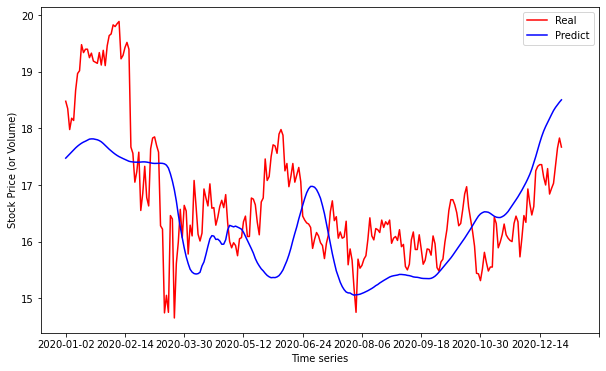

R2Walgreens Boots Alliance (USA)=-0.08058336851196168


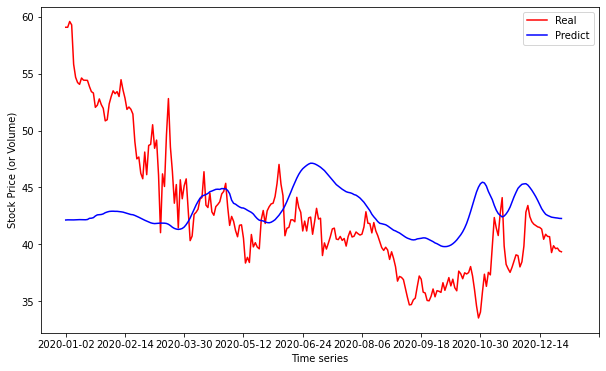

R2Metro (Canada)=0.6225746867661137


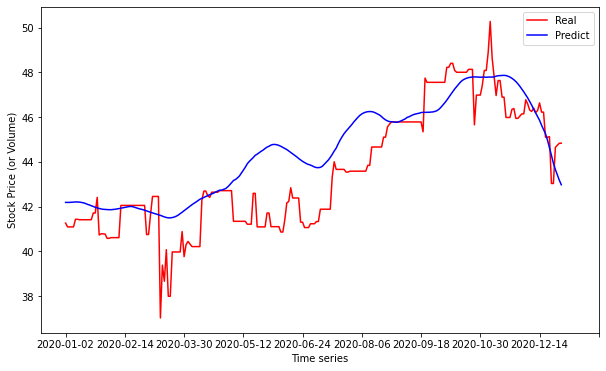

R2Coop Group (Switzerland)=-0.7629985374240675


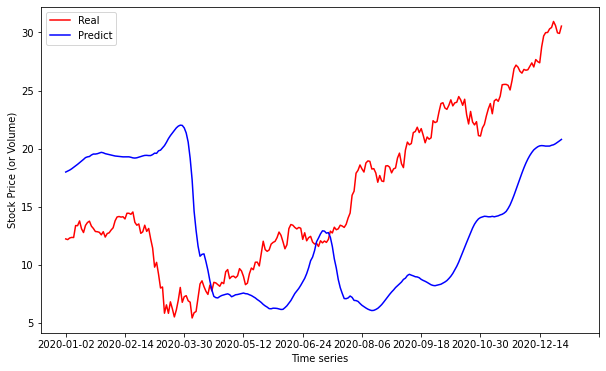

R2J.Sainsbury(Britain)=-0.6067631289088362


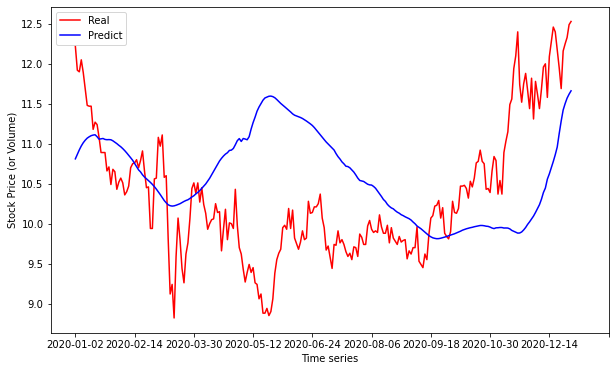

R2Royal Ahold Delhaize(Netherlands)=0.195583359625231


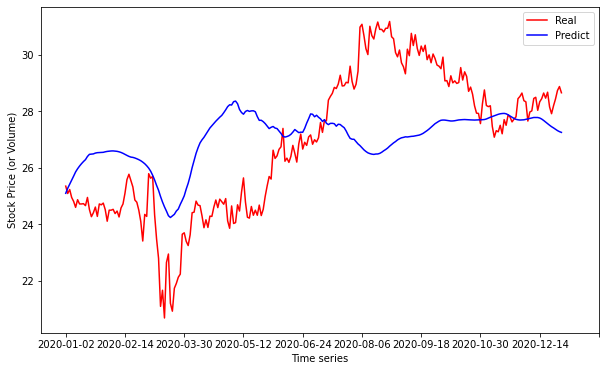

R2Tesco(Britain)=-0.5849604788749849


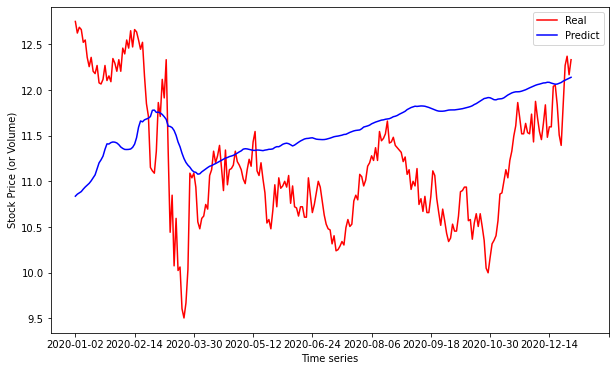

R2Kroger(USA)=0.062465914546379064


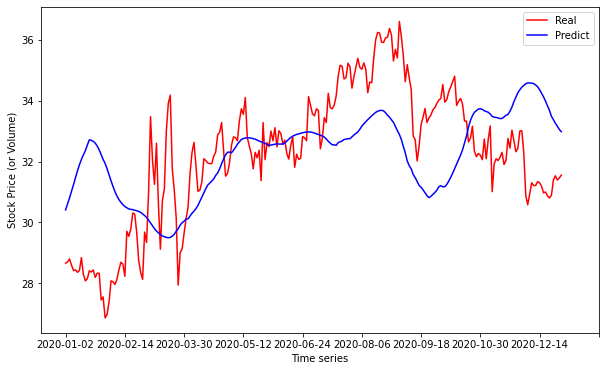

R2AEON(Japan)=-0.7322255750220685


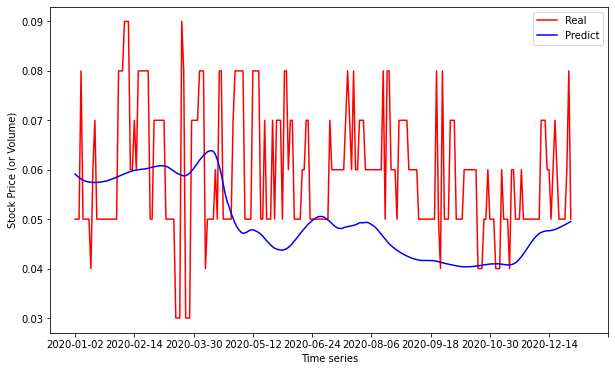

R2Carrefour(France)=0.01721277955572964


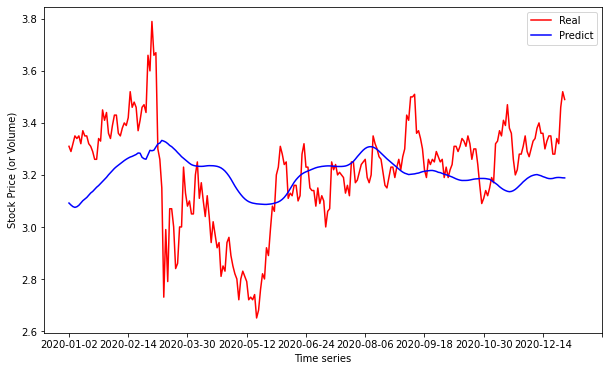

R2George Weston(Canada)=0.13131605127544388


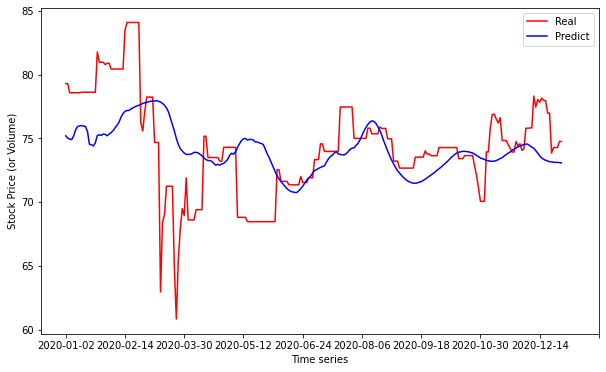

R2-11companies_average=-0.14191259213401078

Preds_Heatmap=Close correlation


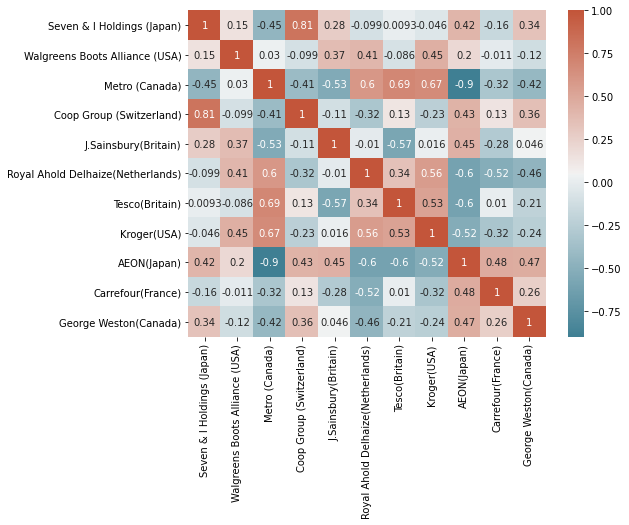

In [36]:
t2 = make_preds(c, nl, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

df1.shape
m = df1.iloc[:,1:].values
print(m[0])
# m = m.reshape(-1, 1)
print(m.shape)
s=StandardScaler()
t1=s.fit_transform(m)
t1

In [ ]:
df1=df1
s1=StandardScaler()
m = df1.iloc[:,1:].values

t1=s1.fit_transform((m[:,1]).reshape(-1, 1))
t2=s1.fit_transform((m[:,2]).reshape(-1, 1))
t3=s1.fit_transform((m[:,3]).reshape(-1, 1))
t4=s1.fit_transform((m[:,4]).reshape(-1, 1))
t5=s1.fit_transform((m[:,5]).reshape(-1, 1))
# t6=s1.fit_transform((m[:,6]).reshape(-1, 1))
t1